# Statistical analysis

This is a frame of the `main` notebook. It contains code to analyse the **SAMSum** dataset and the **training** dataset.

 # **II. Data Processing**


 Here we will process the data inside the SAMSum dataset. Mainly we will keep only 2-characters interactions and transformed the reference summary to first-person summary. We will determine the perspective of the utterance with the last person who has spoken in the dialogue.

 Also we will keep track of the score obtained for each transformations and give a statistical analysis of it to check the efficiency of the new dataset.

 Below is an overview of how the data will be collected. We can retrieve important information such as the names of the characters, the last character who has spoken which will be use to write the prompt.  

# II.1. Analyzing and cleaning data

In [ ]:
def analyse_row(row):
  utterances = row['dialogue'].split("\n")
  last_character = utterances[-1].split(":")[0]
  characters = []

  for utterance in utterances:
    new_character = utterance.split(":")[0]

    if new_character not in characters:
      characters.append(new_character)

  print('Number of characters:', len(characters))

  if len(characters) == 2:
    other_character = characters[0] if last_character == characters[1] else characters[1]
    print('Last character:', last_character)
    print('Other character:', other_character)

    prompt = f"Transform the following third-person sentence into first-person. Replace {last_character}'s pronouns and possessive determiners with first-person counterparts. Replace {other_character}'s pronouns and possessive determiners with second-person counterparts. Adjust verb forms accordingly. Write the transformed sentence only and write this mention at the begining: 'Answer:'. '{row['summary']}'"

    response = get_llama_response([prompt])[0].split("Answer:")[-1]
    print('Reference summary:', row['summary'])
    print('Model response:', response)

sample = dataset['train'].shuffle().select(range(1))
for row in sample:
  print(analyse_row(row))


From the code above we can make a few observations:

- The names of the characters are retreived accordingly.
- The last character is well identified.
- Only two-people dialogues are treated.
- The model response is correctly obtained.

However sometimes the model is not performing very well. It mostly happens when the first name appearing in the reference summary is not the last character who has spoken and they are not grouped together (if the summary starts with 'Andrew and Bernard' and Bernard is the last speaking character, it works fine). Such data will be considered as **critical** observations.

Let's do a statistical overview of the dataset.

First we are going to extract the number of two-people dialogues.

In [ ]:
def two_characters(example):
  characters = set()
  utterances = example['dialogue'].split("\n")

  for utterance in utterances:
    new_character = utterance.split(":")[0]
    if new_character not in characters:
      characters.add(new_character)

  return len(characters) == 2

two_characters_dataset = dataset.filter(two_characters).remove_columns('id')

two_characters_dataset, dataset

Then we are going to observe the number of critical observations.

In [ ]:
def critical_observations(example):
  utterances = example['dialogue'].split("\n")

  last_character = utterances[-1].split(":")[0]
  other_character = ""
  for utterance in utterances:
    if utterance.split(":")[0] != last_character:
      other_character = utterance.split(":")[0]

  summary = example['summary'].split(" ")

  for word in summary:
    if last_character in word:
      return False
    elif other_character in word:
      return True

  return False # None of the characters appear in the summary

critical_dataset = two_characters_dataset.filter(critical_observations)

critical_dataset, two_characters_dataset

Let's calculate the different proportions.

In [ ]:
n_dialogues = dataset['train'].num_rows + dataset['test'].num_rows + dataset['validation'].num_rows
n_two_characters_dialogues = two_characters_dataset['train'].num_rows + two_characters_dataset['test'].num_rows + two_characters_dataset['validation'].num_rows
n_critical_dialogues = critical_dataset['train'].num_rows + critical_dataset['test'].num_rows + critical_dataset['validation'].num_rows

two_characters_proportion = n_two_characters_dialogues/n_dialogues
critical_proportion = n_critical_dialogues/n_two_characters_dialogues


And plot them into a pie chart.

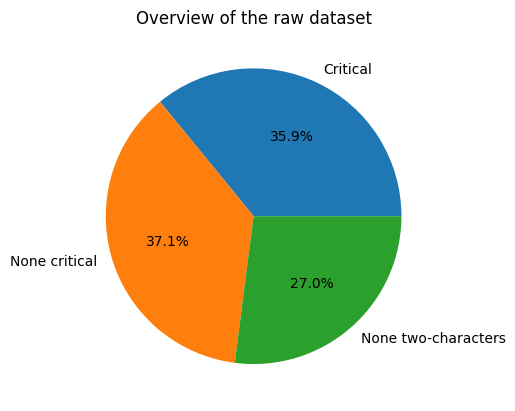

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


y = np.array([two_characters_proportion*critical_proportion, two_characters_proportion*(1-critical_proportion), 1-two_characters_proportion])
labels = ['Critical', 'None critical', 'None two-characters']
plt.pie(y, labels=labels, autopct='%1.1f%%')
plt.title("Overview of the raw dataset")
plt.show()

Here the data correlates the SAMSum Corpus paper with 27% of dialogues containing more than two characters. For the rest of the observations, half of them are considered critical.

# II.2. Creating an adapted dataset

We will continue by working with `two_characters_dataset`. The summaries in the SAMSum Corpus paper are not written in first-person therefore we have to adapt our dataset i.e. rewriting all the summaries in first-person.

In order to write the prompt correctly, we have to extract the name of the characters involved in the dialogues.

In [ ]:
def preprocess_characters(example):
  utterances = example['dialogue'].split("\n")

  last_character = utterances[-1].split(":")[0]
  other_character = ""
  for utterance in utterances:
    if utterance.split(":")[0] != last_character:
      other_character = utterance.split(":")[0]

  example['last_character'] = last_character
  example['other_character'] = other_character
  return example

updated_dataset = two_characters_dataset.map(preprocess_characters)
print(updated_dataset)

for example in updated_dataset['train'].select(range(2)):
  print(example)

Then we are going to write the prompt for each summaries.

In [ ]:
def preprocess_prompt(example):
  prompt = f"Transform the following third-person sentence into first-person. Replace {example['last_character']}'s pronouns and possessive determiners with first-person counterparts. Replace {example['other_character']}'s pronouns and possessive determiners with second-person counterparts. Adjust verb forms accordingly. Write the transformed sentence only and write this mention at the begining: 'Answer:'. '{example['summary']}'"

  example['prompt'] = prompt

  return example

prompt_dataset = updated_dataset.map(preprocess_prompt)
print(prompt_dataset)


for example in prompt_dataset['train'].select(range(2)):
  print(example['prompt'])


Here, we would normally use the **map** attribute to generate the new summaries. However this is not working because of the memory consumption.

We will be using another method and store the generated summaries in a csv file.  

First we have to log on Google Drive.

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/Notification Hub"

Mounted at /content/drive


We are going to access the csv file containing all the generated summaries.

In [ ]:
import csv

file_path = "/content/drive/My Drive/Notification Hub/generated_summaries.csv"
csv_summaries = []

# Open the CSV file and read its content
with open(file_path, 'r', newline='', encoding='utf-8') as file:
    csv_reader = csv.reader(file)

    for row in csv_reader:
        csv_summaries.append(row)

csv_summaries[-1:-5:-1]

We will be adding the generated summary to the dataset. They appear in reverse order so we can use it to our advantage.

In [ ]:
def add_generated_summaries(example, generated_summary):
  example['generated_summary'] = generated_summary

  return example


generated_summaries = csv_summaries[::]
final_dataset = prompt_dataset.map(lambda example: add_generated_summaries(example, generated_summaries.pop()[0]).copy())
print(final_dataset)

for example in final_dataset['train'].select(range(5)):
  print(f"Reference summary: {example['summary']}")
  print(f"Generated summary: {example['generated_summary']}")
  print("\n")

# II.3. Quality and cleaning of the new dataset

We can see that the summaries correspond to one another. Also we can already observe some flaws around the generated summaries.

In order to have a high quality dataset we have to introduce a metric to measure the quality of the summaries we generated in comparison to the summaries in the initial dataset. After defining the ROUGE score, we will only keep the summaries which have a high ROUGE score.





# A. Setting up the ROUGE score




ROUGE is used for evaluating automatic summarization and machine translation software in NLP.

This set of metrics has been first intruce with [Lin, Chin-Yew. 2004. ROUGE: a Package for Automatic Evaluation of Summaries. In Proceedings of the Workshop on Text Summarization Branches Out (WAS 2004), Barcelona, Spain, July 25 - 26, 2004]( https://aclanthology.org/W04-1013.pdf).

We will be using it to compare the model's answer with the original summary. Because both sentences should be close, it means that we should get a rather high ROUGE score.

We are choosing to consider `Rouge-1`, `Rouge-L` and `Rouge-Lsum` because those metrics perform better on short summaries.

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL', 'rougeLsum'], use_stemmer=True)

references = ["Amanda baked cookies and will bring Jerry some tomorrow. ","Olivia and Olivier are voting for liberals in this election. "]
generates =  ["I baked cookies and will bring you some tomorrow. ", "I and I am voting for liberals in this election."]

scores = [scorer.score(reference, generated) for reference, generated in zip(references, generates)]

scores

[{'rouge1': Score(precision=0.7777777777777778, recall=0.7777777777777778, fmeasure=0.7777777777777778),
  'rougeL': Score(precision=0.7777777777777778, recall=0.7777777777777778, fmeasure=0.7777777777777778),
  'rougeLsum': Score(precision=0.7777777777777778, recall=0.7777777777777778, fmeasure=0.7777777777777778)},
 {'rouge1': Score(precision=0.7, recall=0.7, fmeasure=0.7),
  'rougeL': Score(precision=0.7, recall=0.7, fmeasure=0.7),
  'rougeLsum': Score(precision=0.7, recall=0.7, fmeasure=0.7)}]

We can see that the generated summary obtained high scores which is what we except. If the model gives out an answer with an incorrect structure, it will perform very low on the ROUGE score. Therefore we will be keeping only generated summaries with a score higher than **0.5**.

# B. Cleaning and statistical analysis of the new dataset

The last process will be to collect the rouge score of each pair of summaries and keep only the high-rated ones. We will be suppressing every summaries that get a score lower than **0.5**.

In [ ]:
def rouge_score(example):
  reference = example['summary']
  generated = example['generated_summary']

  scores = scorer.score(reference, generated)

  rougeL = scores['rougeL'].fmeasure

  if rougeL > 0.5:
    return True
  else:
    return False


processed_dataset = final_dataset.filter(rouge_score)

processed_dataset

Let's analyse the rouge_score of the given row to see how close the new summaries are to their references.

In [ ]:
def process_rouge_score(example):
  reference = example['summary']
  generated = example['generated_summary']

  scores = scorer.score(reference, generated)
  example['rouge_score'] = scores['rougeL'].fmeasure

  return example

rouge_score_dataset = processed_dataset.map(process_rouge_score)
rouge_score_dataset

In [ ]:
import pandas as pd

rouge_scores = rouge_score_dataset['train']['rouge_score'] + rouge_score_dataset['test']['rouge_score'] + rouge_score_dataset['validation']['rouge_score']

# Create a DataFrame
df = pd.DataFrame(rouge_scores, columns=['Values'])

# Generate summary statistics
summary_stats = df.describe()

summary_stats

,Values
count,11072.000000
mean,0.799854
std,0.095273
min,0.500000
25%,0.740741
50%,0.807692
75%,0.869565
max,1.000000


Overall the results correspond to what we expect as generated summaries should only change the characters's pronouns and possessive determiners to their respective counterparts.

We can see that the max value is **1.0** which is expected because some summaries does not have names in them so should not be changed.

The mean and median values are really closed, therefore we can assume that the scores are evenly distributed around the center, and there are no extreme outliers pulling the mean away from the median.

Let's dive into the distribution.

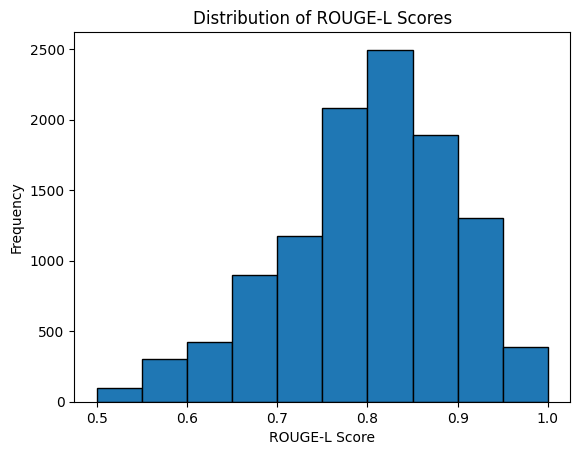

In [ ]:
plt.hist(rouge_scores, bins=10, edgecolor='black')

# Add labels and a title
plt.xlabel('ROUGE-L Score')
plt.ylabel('Frequency')
plt.title('Distribution of ROUGE-L Scores')

# Show the plot
plt.show()

From the plot we can assume that rouge-L follows a normal distribution. Therefore it means that LLama's model has a balanced performance with a satisfying overall performance. This is due to the fact that summaries are relatively short so few changes in words can lead in a decrease of the rouge score.


We will be training our AI model with the following dataset:

In [ ]:
ds = rouge_score_dataset.filter(two_characters).remove_columns(['summary', 'last_character', 'other_character', 'prompt', 'rouge_score'])

ds